**классификатор текстов LSTM + W2V**

Евгений Борисов <esborisov@sevsu.ru>

## Данные

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()        
pd.options.display.max_colwidth = 200 

In [2]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

data = pd.concat([
    pd.read_csv('data/positive.csv.gz',sep=';',header=None),
    pd.read_csv('data/negative.csv.gz',sep=';',header=None),
])

data.columns = ff

data = data[['id','ttext', 'ttype']]

print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

data.sample(10)

negative: 111923 
positive: 114911


,id,ttext,ttype
65826,410372699798511616,@alekc49 @Serge_63 @valentinov_v Легко? Но если в месяц по два раза..то не очень-то легко.)),1
8268,409106401168871424,"не гоже дамам личики кривить,но я же кривляжка:)\nмне можно,но немножко:) http://t.co/YMDdnSRXL1",1
91990,422031029189107714,"@Aleksandroov котики мои,мне вас жаль.\nтолько я не могу помочь ((",-1
27748,412577378767241217,"Антон Логвинов проник на наши склады и исписал, сука, все коробки :(",-1
67505,417312629045334016,"@_tvoy_kosmos_ в точку,и у меня поганое настроение(",-1
110144,411192292519985152,Немного любви в холодном городе :) http://t.co/jqjTkiEmi2,1
79488,419464924281458688,Каникулы быстро проходят :( http://t.co/HUKKifgPJ9,-1
96830,411034551352565760,"Вот многие о политике, а у нас ""пшеничка из яичка"" взошла :)",1
41526,409932447648731136,"@lyana4 Доброе утро, Ляна!))) Отличного дня и настроения!)))",1
106711,424197632362565632,RT @SVeloso4: @PolyaMoore он должин быть нашииим ;(,-1


### очистка данных

In [3]:
import re

In [4]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
      #[r'ё','е'] # замена ё для унификации
      #,[r'</?[a-z]+>',' '] # удаляем xml
      [r'[:;]-*[)D]',' радость ']
      ,[r'\)\)\)*',' радость ']
      ,[r'[:;]\*',' поцелуй ']
      ,[r':\(',' печаль ']
      ,[r'\(\(\(*',' печаль ']
    ]
    return replace_patterns(s,pat).strip()

In [5]:
data['ttext_'] = data['ttext'].progress_apply(string_normalizer)

  0%|          | 0/226834 [00:00<?, ?it/s]

In [6]:
# data

In [7]:
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [8]:
def tokenize(line): # разбиваем предложения на слова
    return    [ 
        t.lower() 
        for t in nltk_tokenize_word(line) 
        if re.match(r'[а-я -]+',t.lower()) and len(t)>1 
        #      if not( (t.lower() in stopwords) or (len(t)<3) ) 
    ] 

In [9]:
data['ttext_'] = data['ttext_'].progress_apply(tokenize)

  0%|          | 0/226834 [00:00<?, ?it/s]

In [10]:
data.sample(10)

,id,ttext,ttype,ttext_
108365,411164474947940352,Q: если нравится парень ты будешь ему намекать или прямым текстом скажешь?)) A: http://t.co/IqgcQn4QfE,1,"[если, нравится, парень, ты, будешь, ему, намекать, или, прямым, текстом, скажешь, радость]"
29706,409630116617011200,@KseniaKozchenko #последнийкруг\nя бы ей отдала последний круг! предательство не прощается!хотя к черту её))) пусть потом не удивляется;),1,"[последнийкруг, бы, ей, отдала, последний, круг, предательство, не, прощается, хотя, черту, её, радость, пусть, потом, не, удивляется, радость]"
26829,412524326467170304,"Ты любишь высокие каблуки? — люблю, но насить не могу к сожалению((( http://t.co/83k3rwTBHN",-1,"[ты, любишь, высокие, каблуки, люблю, но, насить, не, могу, сожалению, печаль]"
83849,410779071971606528,В Астане презентован бургер с кониной. Вот это я понимаю! Оч хочу попробовать!),1,"[астане, презентован, бургер, кониной, вот, это, понимаю, оч, хочу, попробовать]"
44373,409975398802669568,Alanya)\nХочу обратно в Турцию:) http://t.co/QIN04DOd3u,1,"[хочу, обратно, турцию, радость]"
58441,410131481110257664,@alkoltsov а самолеты у них какие?Мне сказали хороший парк:),1,"[самолеты, них, какие, мне, сказали, хороший, парк, радость]"
7258,409094091171827712,"согласна, надо было так и поступать))) http://t.co/j7eWiX3G2k",1,"[согласна, надо, было, так, поступать, радость]"
61372,410291463881097216,Сижу на первой парте с тел. А учительница не видит...)мудак,1,"[сижу, на, первой, парте, тел, учительница, не, видит, мудак]"
41953,414054169960804352,"У тебя есть друзья, с которыми ты познакомился ещё в детском садике? — нет( http://t.co/QEYI1K6mO5",-1,"[тебя, есть, друзья, которыми, ты, познакомился, ещё, детском, садике, нет]"
87883,410818017493532672,@1Hello_Die_ а утром они покажутся тебе просто отвратительными. та же история с фанфиками :D,1,"[утром, они, покажутся, тебе, просто, отвратительными, та, же, история, фанфиками, радость]"


In [11]:
# data[ data['ttext_'].str.len()<1 ]
max_len = data['ttext_'].str.len().max() # максимальная длинна последовательности
max_len

35

In [12]:
data[ data['ttext_'].str.len()<1 ] # пустые последовательности

,id,ttext,ttype,ttext_
66829,410387338087632896,RT @olesyaglee: @ktyekmrf30 http://t.co/fBbOR9RPLn х),1,[]
70030,410465659223810048,RT @MilanaRepina: @LenocPlotnikova ❤спасиииибо) http://t.co/aO0vwsolYd,1,[]
77139,410705991714738176,RT @Mariya_Mila: С @ErmachonokAnton ) http://t.co/LmCxpsSoQG,1,[]
101718,411095547144306688,RT @Dasha_Jenner: @poolyasha П О Л Я \nТ Ы \nХ О Р О Ш А Я : ),1,[]
114606,411364795800354816,RT @sergey0495: http://t.co/dsvJIQP5Tgпробки 10баллов),1,[]
9374,410306860089364480,RT @_Batonchik_: @cekc_tyt @aabdullaeva1 @chemicalechelon @frank_james45 @herlocked @misty_marcie @mywhisper @to_over_kill @whoresdiefirst …,-1,[]
12183,410753661065625600,@Katyaaa_fly @Vituska1998 @daria_hey и я(,-1,[]
21396,411751245129744385,RT @SolarEclipse57: @girl_turner666 @SCOOB_JOE @Geronimo_woohoo @drinkthecyani @SolarEclipse57 @greennwood @BrianMolko_off @bananacookiee @…,-1,[]
28025,412591386681409536,@hasio_original и @whitebro_ http://t.co/dupuQSnm6D,-1,[]
29153,412648375071158272,@VasylevaMasha и я( http://t.co/GilYbA6TzZ,-1,[]


In [13]:
print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

negative: 111923 
positive: 114911


In [14]:
data = data[ data['ttext_'].str.len()>0 ].reset_index(drop=True)
print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

negative: 111909 
positive: 114906


### кодируем слова W2V

https://ruscorpora.ru/new/

https://nlpub.ru/Russian_Distributional_Thesaurus    

In [15]:
import numpy as np
from gensim.models.word2vec import KeyedVectors
# загружаем матрицу word2vec
w2v = KeyedVectors.load_word2vec_format('w2v/all.norm-sz100-w10-cb0-it1-min100.w2v',binary=True,limit=100000)

In [16]:
# 'радость' in w2v # True
# w2v.get_vector('радость').shape

In [17]:
# слова нет в словаре
# 'школота' in w2v # False
# w2v.get_vector('школота') # Error!

In [18]:
X = [ 
 [ w2v.get_vector(w) for w in l if w in w2v ]
 for l in tqdm( data['ttext_'] ) 
]

target = data['ttype']

  0%|          | 0/226815 [00:00<?, ?it/s]

In [19]:
w2v_len = len(X[0][0]) # размер представления W2V
w2v_len

100

In [20]:
# дополняем последовательности нулями до единого формата,
# выкидываем те, что не нашли соответствия в словаре W2V
z = np.zeros(w2v_len) 
target = np.array([ target[i] for i,xi in enumerate(X) if len(xi)>0 ])
X = np.array([ [z]*(max_len-len(xi)) + xi for xi in X if len(xi)>0  ],dtype=np.float32)
X.shape, target.shape

((226122, 35, 100), (226122,))

In [21]:
del w2v

In [22]:
target = (target+1)//2
y = np.eye(max(target)+1,dtype=np.float32)[target] # строим выход нейросети (из 2 нейронов)

In [23]:
from sklearn.model_selection import train_test_split

# делим данные для оценки
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((135673, 35, 100), (135673, 2), (90449, 35, 100), (90449, 2))

In [24]:
del X
del target
del y

## модель

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
torch.__version__

'1.10.2+cu102'

In [27]:
input_dim = w2v_len
hidden_dim = 128
n_classes = 2

class Model(nn.Module):
    def __init__(self, 
                 input_dim=input_dim,  # размер входа
                 hid_dim=hidden_dim,   # размер рекуррентного слоя
                 output_dim=n_classes, # размер выхода
                ):
        super().__init__()
        self._rnn = nn.LSTM( input_dim, hid_dim, batch_first=True) # рекуррентный слой
        self._linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой

    def forward(self,x):
        _, (hidden, _) = self._rnn(x) # обрабатываем входную последовательность
        # print(hidden.shape,out.shape)
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self._linear(hidden) # считаем выход сети
        out = F.softmax(out,dim=1)
        return out 

In [28]:
model = Model()
model

Model(
  (_rnn): LSTM(100, 128, batch_first=True)
  (_linear): Linear(in_features=128, out_features=2, bias=True)
)

In [29]:
# o =  model.forward( torch.Tensor(x_train[:256]) ) # .to(device) )
# o.shape

### обучаем модель

In [30]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [31]:
model = model.to(device)

In [32]:
criterion =  nn.CrossEntropyLoss() # ф-ция потери
optimizer = torch.optim.Adam(model.parameters(), lr=.005) # метод оптимизации

In [33]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader # генератор батчей

# пакуем данные в формат Torch
dataset_train = TensorDataset(torch.tensor(x_train), torch.tensor(y_train) )

In [34]:
from sklearn.metrics import accuracy_score

def accuracy(dataset):
    with torch.set_grad_enabled(False):
        return np.mean([
            accuracy_score(
                y[:,1],
                np.argmax( model(x.to(device)).cpu().numpy(),axis=1 )
            )
            for x,y in DataLoader(dataset, batch_size=len(dataset)//100, shuffle=False)
        ])
        
acc_history = [ accuracy(dataset_train) ] # начальное значение погрешности

In [35]:
%%time

from torch.utils.data import DataLoader # генератор батчей

loss_history = [ ] # значения ф-ции потери
n_epoch = 7 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    
    # получаем батч учебных примеров
    for x,y in DataLoader(dataset_train, batch_size=len(y_train)//100, shuffle=True): 
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_history.append(loss.item()) # дополняем историю изменения значений ф-ции потери
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    acc_history.append( accuracy(dataset_train) ) #значение погрешности

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 27.9 s, sys: 170 ms, total: 28 s
Wall time: 27.7 s


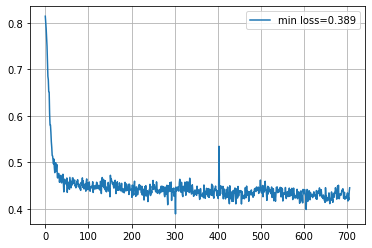

In [36]:
from matplotlib import pyplot as plt
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

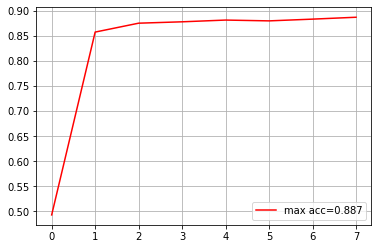

In [37]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),c='r')
plt.grid()
plt.legend()

## проверяем результат

In [38]:
dataset_test = TensorDataset(torch.tensor(x_test), torch.tensor(y_test) )

with torch.set_grad_enabled(False):
    o_test = np.hstack([
            np.argmax( model(x.to(device)).cpu().numpy(),axis=1 )
            for x,_ in DataLoader(dataset_test, batch_size=len(dataset_test)//100, shuffle=False)
        ])
    
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_test,axis=1),o_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     44518
           1       0.88      0.89      0.88     45931

    accuracy                           0.88     90449
   macro avg       0.88      0.88      0.88     90449
weighted avg       0.88      0.88      0.88     90449

